### Турники cox cox cox

In [1]:
!pip install pycox

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 73.7/73.7 kB 581.8 kB/s eta 0:00:00
     ---------------------------------------- 67.6/67.6 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 41.9/41.9 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 28.1/28.1 MB 4.6 MB/s eta 0:00:00
     ------------------------------------- 357.3/357.3 kB 11.2 MB/s eta 0:00:00
     ---------------------------------------- 1.8/1.8 MB 7.0 MB/s eta 0:00:00
     -------------------------------------- 245.3/245.3 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 46.1/46.1 kB ? eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2442 sha256=5238d416f94

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import pandas as pd
import numpy as np
import random
import warnings

import torch # For building the networks 
import torchtuples as tt # Some useful functions
from pycox.models import LogisticHazard

from scipy.stats import kurtosis, skew
from statistics import median, mean

warnings.simplefilter('ignore')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

random.seed(42)
np.random.seed(42)

## Готовимся к тренировке

In [2]:
main = pd.read_csv('data/train.csv')

sample = pd.read_csv('data/sample_submit_naive.csv').drop('predict', axis=1)
sample['target'] = -1

main = pd.concat([main, sample])

In [3]:
clients = pd.read_csv('data/clients.csv')
report_dates = pd.read_csv('data/report_dates.csv', parse_dates=['report_dt'])

transactions = pd.read_csv('data/transactions.csv', parse_dates=['transaction_dttm'])
transactions = transactions.sort_values('transaction_dttm').reset_index(drop=True)

In [5]:
df = (transactions
    .merge(clients)
    .merge(report_dates)
    .eval('day_diff = (report_dt - transaction_dttm).dt.days')
    .eval('abs_tr = abs(transaction_amt)')
    .groupby('user_id')
    .agg(
            last_day_tr =("day_diff", lambda x: min(x))
            , life =("day_diff", lambda x: max(x) - min(x))
            , unique_days =("day_diff", lambda x: len(set(x)))
            , sum_abs_sum_tr = ("abs_tr", lambda x: sum(x))
            , qnt10_abs_sum_tr = ("abs_tr", lambda x: x.quantile(0.1))
            , qnt90_abs_sum_tr = ("abs_tr", lambda x: x.quantile(0.9))
            , mean_abs_sum_tr = ("abs_tr", lambda x: mean(x))
            , median_abs_sum_tr = ("abs_tr", lambda x: median(x))
            , std_abs_sum_tr = ("abs_tr", lambda x: x.std())
            , kurtosis = ("abs_tr", lambda x: kurtosis(x))
            , skew = ("abs_tr", lambda x: skew(x))
        ).reset_index()
    .merge(main)
    .merge(clients)
    .merge(report_dates)
    )

In [6]:
df.replace({'employee_count_nm':{'ОТ 101 ДО 500':6,'БОЛЕЕ 1001':9,'ОТ 501 ДО 1000':7,'ДО 10':1,
                                      'ОТ 11 ДО 50':3,'ОТ 51 ДО 100':5,'БОЛЕЕ 500':8,'ОТ 11 ДО 30':2,
                                      'ОТ 31 ДО 50':4}}, inplace=True)

In [7]:
df['time'] = df['time'].fillna(-1)
df['time'] = df['time'].astype(np.int32)

df['target'] = df['target'].fillna(-1)
df['target'] = df['target'].astype(np.int8)

In [8]:
for column in df.columns:
    df[column] = df[column].fillna(0)

In [9]:
X = df[df['time']!=-1].copy()
y = df[df['time']!=-1][['target', 'time']].copy()

In [10]:
from sklearn.model_selection import train_test_split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=X['report'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33, stratify=X_train['report'])

In [96]:
df.columns

Index(['user_id', 'last_day_tr', 'life', 'unique_days', 'sum_abs_sum_tr',
       'qnt10_abs_sum_tr', 'qnt90_abs_sum_tr', 'mean_abs_sum_tr',
       'median_abs_sum_tr', 'std_abs_sum_tr', 'kurtosis', 'skew', 'target',
       'time', 'report', 'employee_count_nm', 'bankemplstatus', 'customer_age',
       'report_dt'],
      dtype='object')

## Preprocessing

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

In [98]:
cols_standardize = ['sum_abs_sum_tr', 'qnt10_abs_sum_tr', 'qnt90_abs_sum_tr', 'mean_abs_sum_tr', 'median_abs_sum_tr', 'std_abs_sum_tr']
cols_leave = ['last_day_tr', 'life', 'unique_days', 'kurtosis', 'skew', 'employee_count_nm', 'customer_age', 'bankemplstatus']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [99]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_val = x_mapper.transform(X_val).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')
x_eval = x_mapper.transform(df[df['time']==-1]).astype('float32')

In [100]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import torch

In [101]:
num_durations = 30

labtrans = PMF.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['target'].values)
y_train = labtrans.fit_transform(*get_target(y_train))
y_val = labtrans.transform(*get_target(y_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(y_test)

In [102]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [104]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [105]:
model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [106]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [107]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.9459,	val_loss: 0.5603
1:	[0s / 1s],		train_loss: 0.5519,	val_loss: 0.5513
2:	[0s / 2s],		train_loss: 0.5459,	val_loss: 0.5489
3:	[0s / 3s],		train_loss: 0.5431,	val_loss: 0.5549
4:	[0s / 4s],		train_loss: 0.5409,	val_loss: 0.5571
5:	[0s / 5s],		train_loss: 0.5409,	val_loss: 0.5536
6:	[0s / 6s],		train_loss: 0.5410,	val_loss: 0.5464
7:	[1s / 7s],		train_loss: 0.5416,	val_loss: 0.5485
8:	[0s / 8s],		train_loss: 0.5395,	val_loss: 0.5515
9:	[0s / 9s],		train_loss: 0.5398,	val_loss: 0.5511
10:	[0s / 9s],		train_loss: 0.5386,	val_loss: 0.5465
11:	[0s / 10s],		train_loss: 0.5389,	val_loss: 0.5457
12:	[0s / 11s],		train_loss: 0.5369,	val_loss: 0.5484
13:	[0s / 12s],		train_loss: 0.5385,	val_loss: 0.5517
14:	[0s / 13s],		train_loss: 0.5377,	val_loss: 0.5481
15:	[0s / 14s],		train_loss: 0.5373,	val_loss: 0.5542
16:	[0s / 15s],		train_loss: 0.5372,	val_loss: 0.5497
17:	[0s / 15s],		train_loss: 0.5377,	val_loss: 0.5522
18:	[0s / 16s],		train_loss: 0.5361,	val_loss: 0.

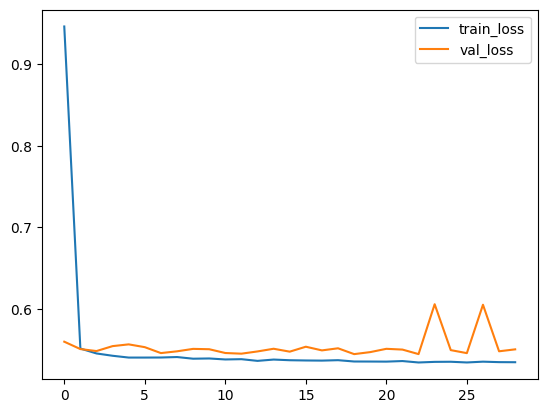

In [108]:
_ = log.plot()

In [109]:
log.to_pandas().val_loss.min()

0.5451202392578125

In [110]:
surv = model.predict_surv_df(x_test)

In [111]:
surv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,12750,12751,12752,12753,12754,12755,12756,12757,12758,12759,12760,12761,12762,12763,12764,12765,12766,12767,12768,12769,12770,12771,12772,12773,12774,12775,12776,12777,12778,12779,12780,12781,12782,12783,12784,12785,12786,12787,12788,12789,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0.000000,0.999997,0.999997,0.999989,0.999998,0.999997,0.999980,0.999998,1.000000,0.999999,0.999989,0.999950,0.999999,0.999998,0.999978,1.000000,0.999994,0.999987,0.999996,0.999994,0.999998,0.999959,1.000000,0.999997,0.999970,1.000000,0.999993,1.000000,0.999995,1.000000,1.000000,0.999999,0.999999,0.999989,0.999989,0.999997,0.999990,0.999992,0.999997,0.999999,0.999997,0.999997,0.999998,0.999993,1.000000,0.999991,0.999999,0.999966,0.999998,0.999987,0.999998,...,0.999998,0.999982,0.999997,0.999996,0.999974,0.999989,1.000000,1.000000,0.999997,0.999999,1.000000,1.000000,0.999996,0.999947,0.999996,0.999996,0.999999,0.999989,1.000000,0.999999,1.000000,0.999993,0.999990,1.000000,0.999995,1.000000,0.999996,0.999999,0.999989,0.999960,0.999994,0.999996,0.999999,1.000000,0.999996,0.999993,0.999999,0.999995,0.999999,0.999997,1.000000,0.999999,0.999960,0.999996,0.999991,1.000000,0.999977,0.999998,1.000000,0.999999
3.137931,0.999141,0.998938,0.998125,0.999370,0.999014,0.997819,0.999141,0.999613,0.999625,0.998654,0.997383,0.999369,0.999189,0.998000,0.999768,0.998728,0.998748,0.998809,0.999008,0.998966,0.997467,0.999737,0.999079,0.997291,0.999788,0.998272,0.999684,0.998714,0.999685,0.999737,0.999367,0.999548,0.998240,0.998388,0.999024,0.998552,0.998226,0.999032,0.999419,0.999075,0.999203,0.999142,0.998576,0.999598,0.998662,0.999455,0.995656,0.999306,0.997825,0.999029,...,0.999269,0.998010,0.999464,0.998656,0.996852,0.998604,0.999631,0.999754,0.998786,0.999776,0.999756,0.999701,0.998872,0.995538,0.999042,0.999031,0.999227,0.998156,0.999914,0.999321,0.999648,0.998488,0.997680,0.999690,0.998813,0.999795,0.998832,0.999516,0.998213,0.996728,0.998363,0.998741,0.999332,0.999737,0.998843,0.998207,0.999672,0.998815,0.999426,0.999085,0.999791,0.999489,0.997284,0.998647,0.998406,0.999824,0.997195,0.999084,0.999832,0.999494
6.275862,0.998522,0.998293,0.997543,0.998823,0.998395,0.996501,0.998606,0.999273,0.999301,0.997525,0.994966,0.998958,0.998681,0.996449,0.999514,0.998192,0.997736,0.998141,0.998022,0.998596,0.995701,0.999577,0.998427,0.996141,0.999568,0.997526,0.999453,0.997983,0.999418,0.999433,0.998946,0.999173,0.997636,0.997281,0.998400,0.997368,0.997709,0.998374,0.999052,0.998367,0.998707,0.998630,0.997975,0.999289,0.997752,0.999076,0.994153,0.998602,0.997162,0.998628,...,0.998729,0.996693,0.998666,0.997954,0.995251,0.997637,0.999364,0.999459,0.998206,0.998893,0.999497,0.999384,0.998370,0.993407,0.998340,0.998279,0.998800,0.997618,0.999776,0.998836,0.999323,0.997913,0.996817,0.999369,0.998047,0.999577,0.998174,0.999158,0.997585,0.995770,0.997702,0.998192,0.998925,0.999503,0.998122,0.997654,0.999288,0.998152,0.998943,0.998437,0.999515,0.999127,0.995449,0.998114,0.997423,0.999632,0.996525,0.998503,0.999592,0.999143
9.413793,0.997829,0.997557,0.995885,0.998172,0.997577,0.994415,0.997974,0.998948,0.998960,0.996293,0.992002,0.998450,0.998052,0.994073,0.999278,0.997363,0.996779,0.997307,0.996920,0.997720,0.992294,0.999169,0.997638,0.993309,0.999237,0.996338,0.999139,0.996988,0.999144,0.999152,0.998482,0.998786,0.996200,0.995894,0.997638,0.995813,0.995747,0.997649,0.998561,0.997563,0.998120,0.997991,0.996841,0.998939,0.996673,0.998641,0.991542,0.998044,0.995216,0.997901,...,0.998119,0.994785,0.997490,0.997047,0.988302,0.996654,0.999045,0.999209,0.997367,0.998161,0.999258,0.999092,0.997536,0.987158,0.997421,0.997134,0.998265,0.996176,0.999643,0.998291,0.999005,0.996763,0.995395,0.999059,0.997096,0.999375,0.997216,0.998769,0.996472,0.994048,0.996358,0.997254,0.998331,0.999275,0.996990,0.993629,0.998968,0.997058,0.998419,0.

In [112]:
surv = model.interpolate(10).predict_surv_df(x_test)

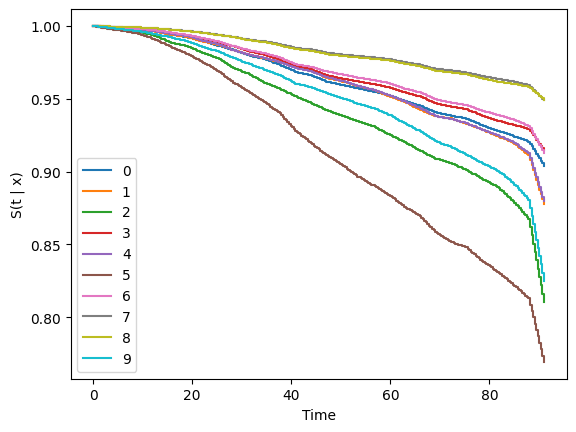

In [113]:
import matplotlib.pyplot as plt

surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [114]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [115]:
ev.concordance_td('antolini')

0.7324126767345245

In [116]:
surv = model.predict_surv_df(x_eval)

In [117]:
sample = pd.read_csv('data/sample_submit_naive.csv')
sample['predict'] = surv.sum()

sample.to_csv('submit_baseline_pycox_pmf.csv', index=False)